**Set environment**

In [1]:
suppressWarnings(suppressMessages(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import FCC data

In [2]:
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.screened.fcc.total.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath, show_col_types=FALSE)

dat_peak_atac_fcc_total = dat
print(dim(dat))
head(dat)

[1] 732434      7


Chrom,Start,End,Peak,Score,Assay_Type,Assay_Label
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
chr1,100006256,100006880,chr1:100006256-100006880,-0.01311792,ASTARR,ASTARR_T
chr1,100010437,100010915,chr1:100010437-100010915,-0.80687947,ASTARR,ASTARR_T
chr1,10002087,10003910,chr1:10002087-10003910,-0.34892859,ASTARR,ASTARR_T
chr1,100021298,100021629,chr1:100021298-100021629,-1.03799571,ASTARR,ASTARR_T
chr1,100023727,100023976,chr1:100023727-100023976,-0.19100207,ASTARR,ASTARR_T
chr1,100027983,100029702,chr1:100027983-100029702,-0.18001582,ASTARR,ASTARR_T


In [3]:
fdiry = file.path(FD_RES, "results", "region", "KS91_K562_ASTARRseq_peak_macs_input", "summary")
fname = "peak.summary.ccre_v4.tsv"
fpath = file.path(fdiry, fname)

dat = read_tsv(fpath, show_col_types=FALSE)

dat_peak_atac_annotation_ccres = dat
print(dim(dat))
head(dat)

[1] 231554      7


Peak,Annotation,Label,Count,Region,Score,Note
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>
chr1:10015-10442,ccre_v4,Low-DNase,1,chr1:10033-10250,0,EH38E2776516:Low-DNase
chr1:16015-16477,ccre_v4,Low-DNase,1,chr1:16097-16381,0,EH38E3951272:Low-DNase
chr1:17237-17772,ccre_v4,Low-DNase,1,chr1:17343-17642,0,EH38E3951273:Low-DNase
chr1:28903-29613,ccre_v4,Low-DNase,1,chr1:29320-29517,0,EH38E3951274:Low-DNase
chr1:115411-115986,ccre_v4,CA-CTCF,1,chr1:115562-115912,0,EH38E3951280:CA-CTCF
chr1:118518-118743,ccre_v4,Low-DNase,1,chr1:118508-118826,0,EH38E3951281:Low-DNase


In [26]:
vec = c("PLS", "pELS", "dELS")
dat = dat_peak_atac_annotation_ccres
dat = dat %>% dplyr::filter(Label %in% vec) %>% dplyr::select(Peak, Label)


dat_peak_annot = dat
print(dim(dat))
head(dat)

[1] 39446     2


Peak,Label
<chr>,<chr>
chr1:137737-139544,pELS
chr1:777949-779437,PLS
chr1:826754-828040,PLS
chr1:903633-905556,PLS
chr1:903633-905556,pELS
chr1:923417-925194,PLS


In [33]:
dat = dat_peak_atac_fcc_total
dat = dat %>% 
    dplyr::left_join(dat_peak_annot, by="Peak", relationship="many-to-many") %>%
    dplyr::select(Peak, Score, Assay_Type, Label) %>%
    dplyr::mutate(Label = ifelse(is.na(Label), "None", Label))

tmp = dat %>% 
    dplyr::filter(Label == "None") %>%
    dplyr::group_by(Assay_Type) %>%
    dplyr::summarize(Mean = mean(Score), SD = sd(Score))

dat = dat %>%
    dplyr::left_join(tmp, by = "Assay_Type") %>%
    dplyr::mutate(ZScore = (Score - Mean) / SD)

dat_peak_score_label = dat
head(dat)

Peak,Score,Assay_Type,Label,Mean,SD,ZScore
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
chr1:100006256-100006880,-0.01311792,ASTARR,None,0.003048254,0.5850602,-0.02763164
chr1:100010437-100010915,-0.80687947,ASTARR,None,0.003048254,0.5850602,-1.38434934
chr1:10002087-10003910,-0.34892859,ASTARR,None,0.003048254,0.5850602,-0.60160789
chr1:100021298-100021629,-1.03799571,ASTARR,None,0.003048254,0.5850602,-1.77937916
chr1:100023727-100023976,-0.19100207,ASTARR,None,0.003048254,0.5850602,-0.33167582
chr1:100027983-100029702,-0.18001582,ASTARR,None,0.003048254,0.5850602,-0.31289783


In [35]:
fun_bstrap_interveral = function(vec_num, fun = `mean`, num_iteration = 1000, num_seed = 123){
    ### init
    set.seed(num_seed)
    
    ### column: num_iteraction
    ### row:    length(vec_num)
    mat = replicate(
        num_iteration,
        sample(vec_num, replace = TRUE)
    )

    vec = apply(mat, 2, fun)
    res = quantile(vec, probs = c(0, 0.025, 0.25, 0.5, 0.75, 0.975, 1))
    res = c(res, mean(vec))
    names(res) = c("Min", "Ci95_Lw", "Q1", "Q2", "Q3", "Ci95_Up", "Max", "Mean")
    return(res)
}

In [36]:
dat = dat_peak_score_label

lst = split(dat, dat$Assay_Type)
lst = lapply(lst, function(dat){
    lst_inner = split(dat$ZScore, dat$Label)
    lst_inner = lapply(lst_inner, fun_bstrap_interveral)
    dat = bind_rows(lst_inner, .id = "Labels")
    return(dat)
})
dat = bind_rows(lst, .id = "Assay_Type")
dat_peak_score_summary = dat
head(dat)

Assay_Type,Labels,Min,Ci95_Lw,Q1,Q2,Q3,Ci95_Up,Max,Mean
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASTARR,dELS,1.071567709,1.089651853,1.101542591,1.1079224779,1.114525551,1.128797664,1.145240690,1.108085e+00
ASTARR,None,-0.005969926,-0.004303719,-0.001515391,-0.0001809264,0.001356605,0.004039686,0.006632634,-8.866058e-05
ASTARR,pELS,0.618940713,0.634799617,0.648382224,0.6556880338,0.663573299,0.677637278,0.687319469,6.559353e-01
ASTARR,PLS,0.350806164,0.365836463,0.382876565,0.3910615872,0.399409842,0.415194662,0.428482141,3.909445e-01
CRISPRi-Growth,dELS,-0.073153826,-0.063495445,-0.052188286,-0.0461206412,-0.039802843,-0.027252958,-0.017378006,-4.595395e-02
CRISPRi-Growth,None,-0.018715284,-0.008809606,-0.003021852,-0.0001540435,0.002885397,0.007979548,0.011728551,-1.899929e-04


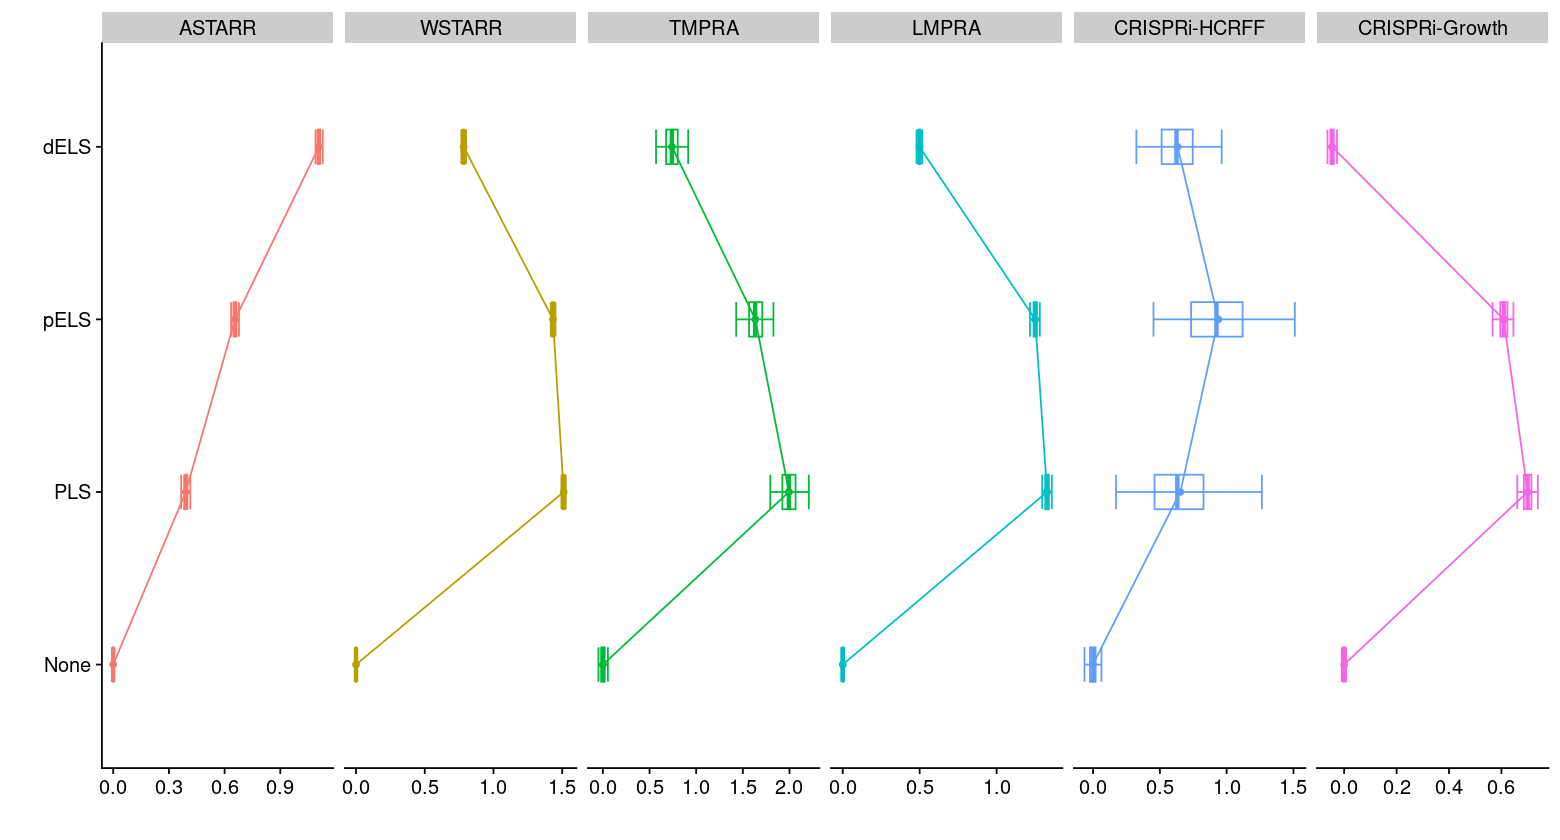

In [37]:
vec_txt_assay = c("ASTARR", "WSTARR", "TMPRA", "LMPRA", "CRISPRi-HCRFF", "CRISPRi-Growth")
vec_txt_label = c("None", "PLS", "pELS", "dELS")#, "PLS;pELS", "dELS;pELS", "PLS;dELS;pELS")

dat = dat_peak_score_summary
dat = dat %>% 
    dplyr::filter(Assay_Type %in% vec_txt_assay) %>%
    dplyr::mutate(
        Labels     = factor(Labels, levels=vec_txt_label),
        Assay_Type = factor(Assay_Type, levels=vec_txt_assay)
    )

gpt = ggplot(dat) + 
    geom_errorbar(
        aes(
            x     = Labels, 
            ymin  = Ci95_Lw, 
            ymax  = Ci95_Up,
            group = Assay_Type, 
            color = Assay_Type
           ), 
        width = 0.2
    ) +
    geom_crossbar(
        aes(
            x     = Labels, 
            y     = Q2,
            ymin  = Q1, 
            ymax  = Q3,
            group = Assay_Type, 
            color = Assay_Type
           ), 
        width = 0.2
    ) +
    geom_line(
        aes(
            x     = Labels, 
            y     = Mean, 
            group = Assay_Type, 
            color = Assay_Type)
    ) +
    geom_point(
        aes(
            x     = Labels, 
            y     = Mean, 
            group = Assay_Type, 
            color = Assay_Type)
    ) +
    labs(x="", y="") +
    theme_cowplot() +
    coord_flip() +
    facet_grid(.~Assay_Type, scales = "free") +
    theme(legend.position = "None")
options(repr.plot.height=7, repr.plot.width = 13)
print(gpt)

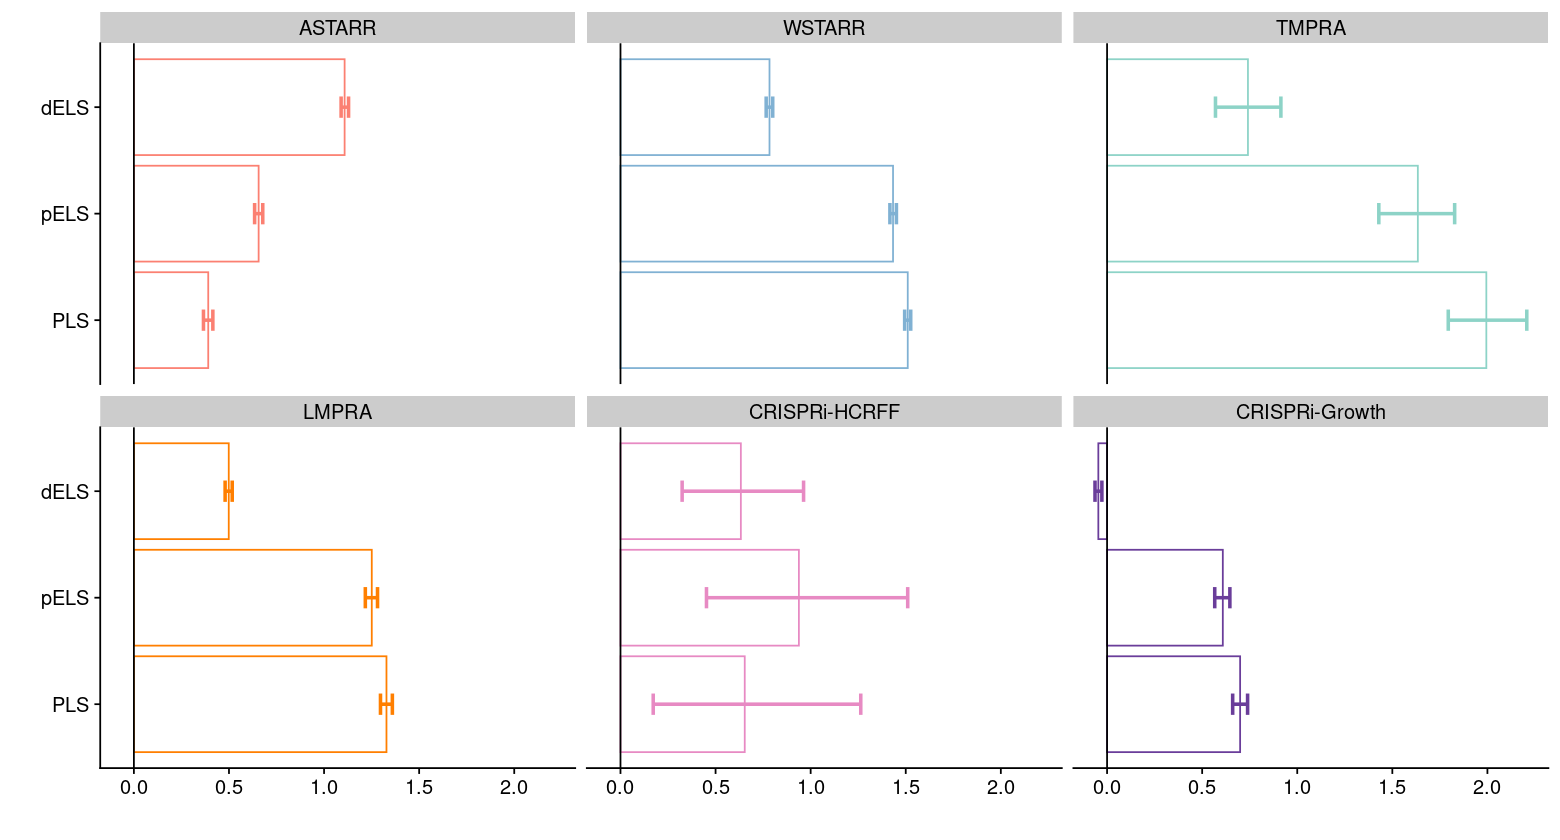

In [68]:
vec_txt_assay = c("ASTARR", "WSTARR", "TMPRA", "LMPRA", "CRISPRi-HCRFF", "CRISPRi-Growth")
vec_txt_label = c("PLS", "pELS", "dELS") #, "PLS;pELS", "dELS;pELS", "PLS;dELS;pELS")
vec_txt_color = c("ASTARR" = "#fb8072", 
                  "WSTARR" = "#80b1d3", 
                  "TMPRA" = "#8dd3c7", 
                  "LMPRA" = "#ff7f00",
                  "CRISPRi-HCRFF" = "#e78ac3", 
                  "CRISPRi-Growth" = "#6a3d9a")

dat = dat_peak_score_summary
dat = dat %>% 
    dplyr::filter(Assay_Type %in% vec_txt_assay) %>%
    dplyr::filter(Labels     %in% vec_txt_label) %>%
    dplyr::mutate(
        Labels     = factor(Labels,     levels=vec_txt_label),
        Assay_Type = factor(Assay_Type, levels=vec_txt_assay)
    )

gpt = ggplot(dat) + 
    geom_col(
        aes(
            x     = Labels, 
            y     = Mean,
            group = Assay_Type,
            color = Assay_Type
        ),
        position = "dodge",
        fill = "white"
    ) +
    geom_errorbar(
        aes(
            x     = Labels, 
            ymin  = Ci95_Lw, 
            ymax  = Ci95_Up,
            group = Assay_Type, 
            color = Assay_Type
           ), 
        width = 0.2,
        size  = 1
    ) +
    geom_hline(yintercept = 0, color="black") +
    labs(x="", y="") +
    scale_color_manual(values = vec_txt_color) +
    theme_cowplot() +
    coord_flip() +
    facet_wrap(~Assay_Type, nrow=2) +
    theme(legend.position = "None")

options(repr.plot.height=7, repr.plot.width = 13)
print(gpt)

In [ ]:
vec_txt_assay = c("ASTARR", "WSTARR", "TMPRA", "LMPRA", "CRISPRi-HCRFF", "CRISPRi-Growth")
vec_txt_label = c("PLS", "pELS", "dELS")
vec_txt_color = c("ASTARR" = "#fb8072", "WSTARR" = "#80b1d3", "TMPRA" = "#8dd3c7", "LMPRA" = "#ff7f00",
                  "CRISPRi-HCRFF" = "#e78ac3", "CRISPRi-Growth" = "#6a3d9a")
dat = dat_peak_score_diff
dat = dat %>% 
    dplyr::filter(Assay_Type %in% vec_txt_assay) %>%
    dplyr::filter(Labels	 %in% vec_txt_label) %>%
    dplyr::mutate(
        Labels     = factor(Labels,     levels=vec_txt_label),
        Assay_Type = factor(Assay_Type, levels=vec_txt_assay)
    )

gpt = ggplot(dat, aes(x=Labels, y=Diff, group = Assay_Type, fill=Assay_Type)) + 
    geom_col(position = "dodge") +
    geom_hline(yintercept = 0) +
    labs(x="", y="Differece of effect size to background") +
    scale_fill_manual(values = vec_txt_color) +
    theme_cowplot() +
    coord_flip() +
    facet_wrap(~Assay_Type, nrow=2, scales = "free_x") +
    theme(legend.position = "None")
options(repr.plot.height=7, repr.plot.width = 12)
print(gpt)
ggsave("fig.fcc_signal.ccres.difference.pdf", gpt, height=7, width=11)
ggsave("fig.fcc_signal.ccres.difference.png", gpt, height=7, width=11, units = "in")

In [4]:
vec = c("PLS", "pELS", "dELS")
dat = dat_peak_atac_annotation_ccres
dat = dat %>% dplyr::filter(Label %in% vec) %>% dplyr::select(Peak, Label)


dat_peak_annot = dat
print(dim(dat))
head(dat)

[1] 39446     2


Peak,Label
<chr>,<chr>
chr1:137737-139544,pELS
chr1:777949-779437,PLS
chr1:826754-828040,PLS
chr1:903633-905556,PLS
chr1:903633-905556,pELS
chr1:923417-925194,PLS


In [6]:
dat = dat_peak_atac_fcc_total
dat = dat %>% 
    dplyr::left_join(dat_peak_annot, by="Peak", relationship="many-to-many") %>%
    dplyr::select(Peak, Score, Assay_Type, Label) %>%
    dplyr::mutate(Label = ifelse(is.na(Label), "None", Label))

#dat = dat %>%
#    dplyr::group_by(Peak, Score, Assay_Type) %>%
#    dplyr::summarize(
#        Labels  = paste(Label, collapse=";"),
#        .groups = "drop"
#    )

dat_peak_score_label = dat
head(dat)

Peak,Score,Assay_Type,Label
<chr>,<dbl>,<chr>,<chr>
chr1:100006256-100006880,-0.01311792,ASTARR,None
chr1:100010437-100010915,-0.80687947,ASTARR,None
chr1:10002087-10003910,-0.34892859,ASTARR,None
chr1:100021298-100021629,-1.03799571,ASTARR,None
chr1:100023727-100023976,-0.19100207,ASTARR,None
chr1:100027983-100029702,-0.18001582,ASTARR,None


In [7]:
dat = dat_peak_score_label
table(dat$Label)


  dELS   None   pELS    PLS 
 72212 592170  57230  56351 

In [13]:
fun_bstrap_interveral = function(vec_num, fun = `mean`, num_iteration = 1000, num_seed = 123){
    ### init
    set.seed(num_seed)
    
    ### column: num_iteraction
    ### row:    length(vec_num)
    mat = replicate(
        num_iteration,
        sample(vec_num, replace = TRUE)
    )

    vec = apply(mat, 2, fun)
    res = quantile(vec, probs = c(0, 0.025, 0.25, 0.5, 0.75, 0.975, 1))
    res = c(res, mean(vec))
    names(res) = c("Min", "Ci95_Lw", "Q1", "Q2", "Q3", "Ci95_Up", "Max", "Mean")
    return(res)
}

In [14]:
x = c(1,2, 3, 4, 5, 10, 22, 5)
fun_bstrap_interveral(x)

Min   Ci95_Lw        Q1        Q2        Q3   Ci95_Up       Max      Mean 
 2.000000  2.996875  4.750000  6.375000  8.125000 11.750000 16.000000  6.594625

In [15]:
dat = dat_peak_score_label
#dat = dat %>% dplyr::filter(Assay_Type == "CRISPRi-HCRFF")

lst = split(dat, dat$Assay_Type)
lst = lapply(lst, function(dat){
    lst_inner = split(dat$Score, dat$Label)
    lst_inner = lapply(lst_inner, fun_bstrap_interveral)
    dat = bind_rows(lst_inner, .id = "Labels")
    return(dat)
})
dat = bind_rows(lst, .id = "Assay_Type")
dat_peak_score_summary = dat
head(dat)

Assay_Type,Labels,Min,Ci95_Lw,Q1,Q2,Q3,Ci95_Up,Max,Mean
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ASTARR,dELS,0.6299798934,0.6405602070,0.647517005,0.651249623,0.65511282,0.663462863,0.673083024,0.651344806
ASTARR,None,-0.0004445124,0.0005303193,0.002161659,0.002942401,0.00384195,0.005411714,0.006928744,0.002996382
ASTARR,pELS,0.3651658438,0.3744442579,0.382390901,0.386665239,0.39127859,0.399506869,0.405171534,0.386809887
ASTARR,PLS,0.2082909856,0.2170846158,0.227054102,0.231842832,0.23672706,0.245962135,0.253736110,0.231774318
CRISPRi-Growth,dELS,-0.0309890338,-0.0291826455,-0.027067890,-0.025933070,-0.02475146,-0.022404284,-0.020557391,-0.025901895
CRISPRi-Growth,None,-0.0208074991,-0.0189548594,-0.017872387,-0.017336026,-0.01676757,-0.015814817,-0.015113648,-0.017342750


In [16]:
dat = dat_peak_score_summary
table(dat$Labels)


dELS None pELS  PLS 
   8    8    8    8 

In [81]:
dat = dat_peak_score_summary
table(dat$Labels)


         dELS     dELS;pELS          None          pELS           PLS 
            8             8             8             8             8 
PLS;dELS;pELS      PLS;pELS 
            7             8 

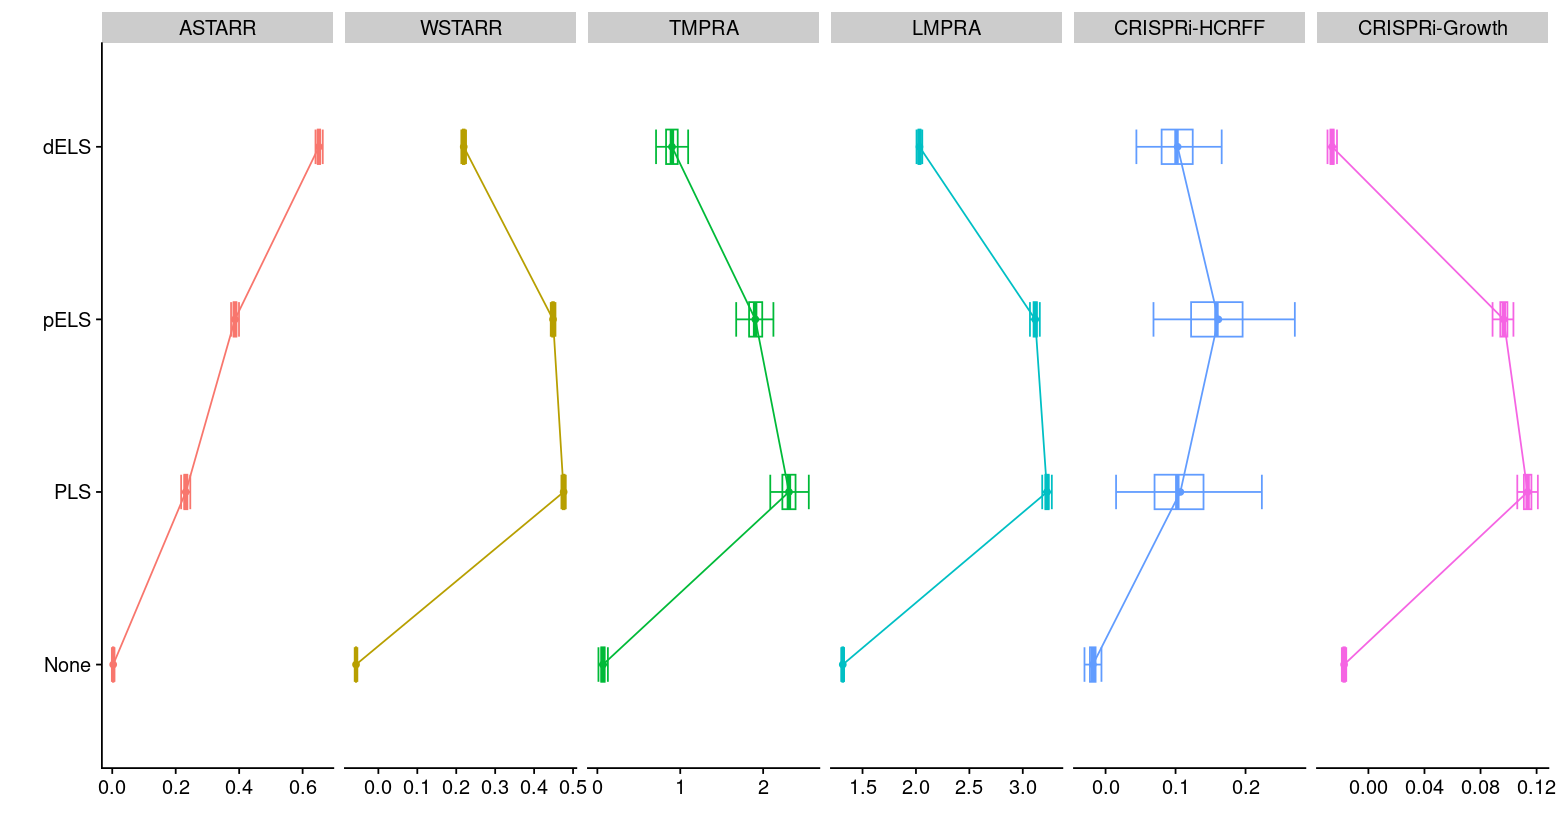

In [20]:
vec_txt_assay = c("ASTARR", "WSTARR", "TMPRA", "LMPRA", "CRISPRi-HCRFF", "CRISPRi-Growth")
vec_txt_label = c("None", "PLS", "pELS", "dELS")#, "PLS;pELS", "dELS;pELS", "PLS;dELS;pELS")

dat = dat_peak_score_summary
dat = dat %>% 
    dplyr::filter(Assay_Type %in% vec_txt_assay) %>%
    dplyr::mutate(
        Labels = factor(Labels, levels=vec_txt_label),
        Assay_Type = factor(Assay_Type, levels=vec_txt_assay)
    )

gpt = ggplot(dat) + 
    geom_errorbar(
        aes(
            x     = Labels, 
            ymin  = Ci95_Lw, 
            ymax  = Ci95_Up,
            group = Assay_Type, 
            color = Assay_Type
           ), 
        width = 0.2
    ) +
    geom_crossbar(
        aes(
            x     = Labels, 
            y     = Q2,
            ymin  = Q1, 
            ymax  = Q3,
            group = Assay_Type, 
            color = Assay_Type
           ), 
        width = 0.2
    ) +
    geom_line(
        aes(
            x     = Labels, 
            y     = Mean, 
            group = Assay_Type, 
            color = Assay_Type)
    ) +
    geom_point(
        aes(
            x     = Labels, 
            y     = Mean, 
            group = Assay_Type, 
            color = Assay_Type)
    ) +
    labs(x="", y="") +
    theme_cowplot() +
    coord_flip() +
    facet_grid(.~Assay_Type, scales = "free") +
    theme(legend.position = "None")
options(repr.plot.height=7, repr.plot.width = 13)
print(gpt)

In [21]:
dat = dat_peak_score_summary
dat = dat %>% dplyr::select(Assay_Type, Labels, Mean)
tmp = dat %>% 
    dplyr::filter(Labels == "None") %>% 
    tidyr::spread(Labels, Mean)
dat = dat %>% 
    dplyr::left_join(tmp, by="Assay_Type") %>% 
    dplyr::mutate(Diff = Mean - None) %>%
    dplyr::filter(Labels != "None")

dat_peak_score_diff = dat
print(dim(dat))
head(dat)

[1] 24  5


Assay_Type,Labels,Mean,None,Diff
<chr>,<chr>,<dbl>,<dbl>,<dbl>
ASTARR,dELS,0.65134481,0.002996382,0.648348424
ASTARR,pELS,0.38680989,0.002996382,0.383813504
ASTARR,PLS,0.23177432,0.002996382,0.228777936
CRISPRi-Growth,dELS,-0.02590189,-0.017342750,-0.008559145
CRISPRi-Growth,pELS,0.09651846,-0.017342750,0.113861206
CRISPRi-Growth,PLS,0.11354225,-0.017342750,0.130885002


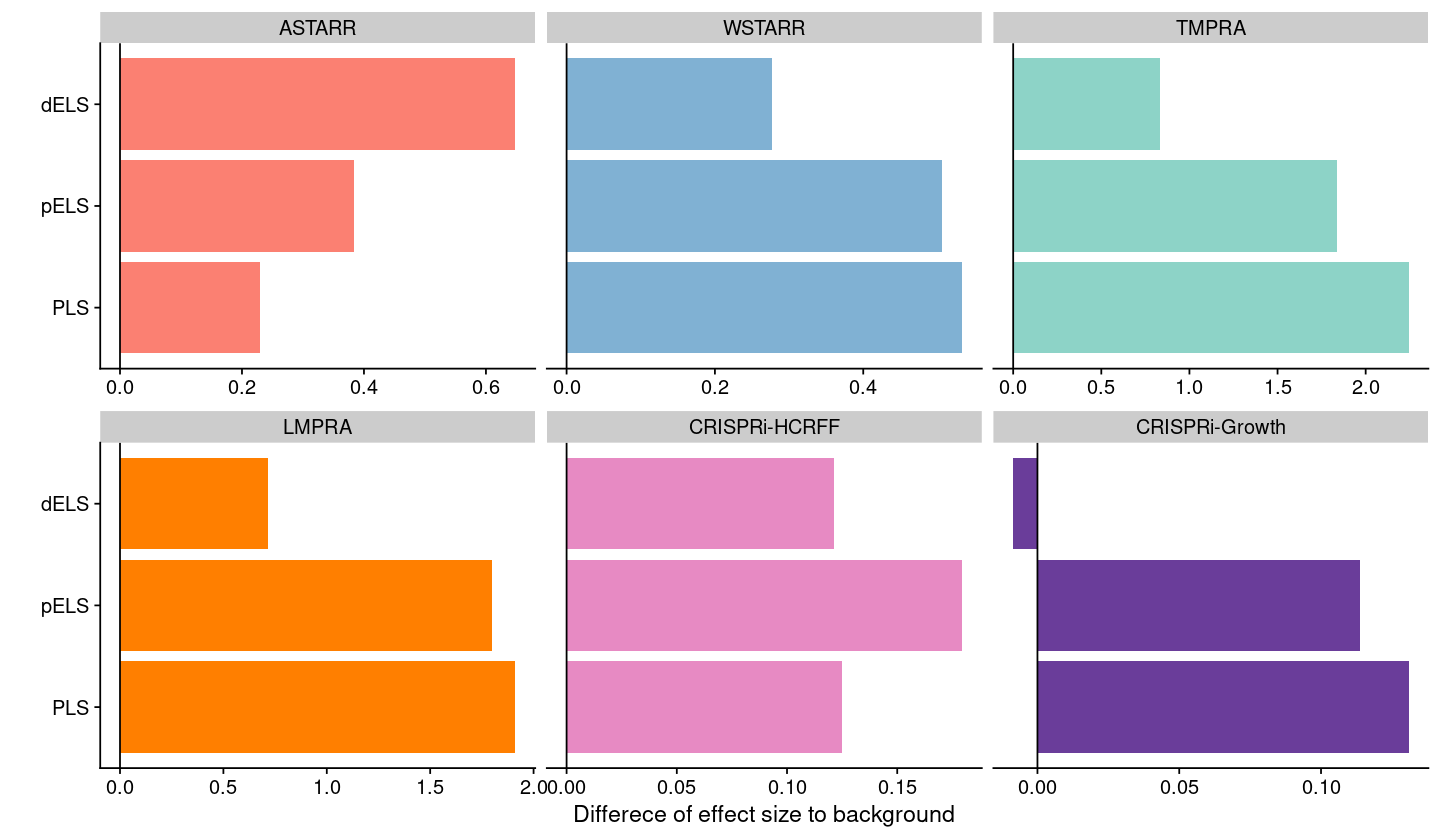

In [22]:
vec_txt_assay = c("ASTARR", "WSTARR", "TMPRA", "LMPRA", "CRISPRi-HCRFF", "CRISPRi-Growth")
vec_txt_label = c("PLS", "pELS", "dELS", "PLS;pELS", "dELS;pELS", "PLS;dELS;pELS")
vec_txt_color = c("ASTARR" = "#fb8072", "WSTARR" = "#80b1d3", "TMPRA" = "#8dd3c7", "LMPRA" = "#ff7f00",
                  "CRISPRi-HCRFF" = "#e78ac3", "CRISPRi-Growth" = "#6a3d9a")
dat = dat_peak_score_diff
dat = dat %>% 
    dplyr::filter(Assay_Type %in% vec_txt_assay) %>%
    dplyr::mutate(
        Labels = factor(Labels, levels=vec_txt_label),
        Assay_Type = factor(Assay_Type, levels=vec_txt_assay)
    )

gpt = ggplot(dat, aes(x=Labels, y=Diff, group = Assay_Type, fill=Assay_Type)) + 
    geom_col(position = "dodge") +
    geom_hline(yintercept = 0) +
    labs(x="", y="Differece of effect size to background") +
    scale_fill_manual(values = vec_txt_color) +
    theme_cowplot() +
    coord_flip() +
    facet_wrap(~Assay_Type, nrow=2, scales = "free_x") +
    theme(legend.position = "None")
options(repr.plot.height=7, repr.plot.width = 12)
print(gpt)
ggsave("fig.fcc_signal.ccres.difference.pdf", gpt, height=7, width=11)
ggsave("fig.fcc_signal.ccres.difference.png", gpt, height=7, width=11, units = "in")

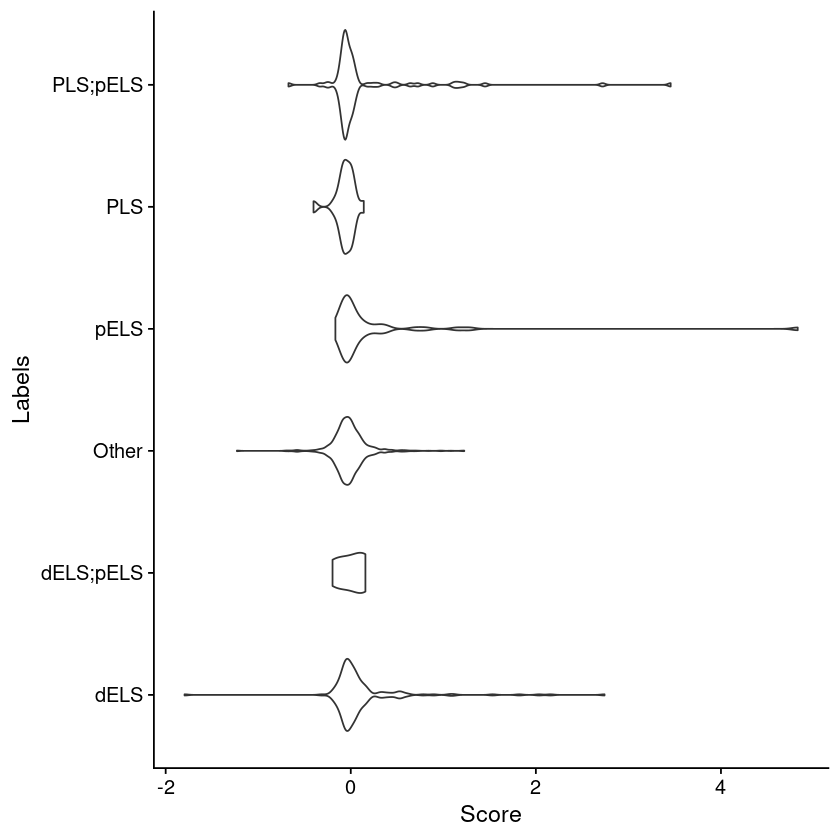

In [23]:
dat = dat_peak_score_label
dat = dat %>% dplyr::filter(Assay_Type == "CRISPRi-HCRFF")
#dat = dat %>% dplyr::filter(Assay_Type %in% c("ASTARR", "CRISPRi-HCRFF"))

gpt = ggplot(dat, aes(x=Labels, y=Score)) + 
    geom_violin() + 
    theme_cowplot() +
    coord_flip()
print(gpt)